In [65]:
import pandas as pd
import numpy as np
import polars as pl
import datetime
import sqlite3

import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.metrics import mean_absolute_error
import time
import pickle
from scipy.stats import norm
from mapie.regression import MapieQuantileRegressor

import warnings
warnings.filterwarnings('ignore')

import sys
import os
from pathlib import Path
PROJ_ROOT = Path(os.getcwd()).parent # add project root file to the python paths
sys.path.append(str(PROJ_ROOT))

path_to_db = str(PROJ_ROOT) + "/data/processed/option_prices_reproduction_processed.db"

## Load data from DB, prepare it for the run on the cluster

In [66]:
# Connection to the local SQLite database
conn = sqlite3.connect(path_to_db)

In [67]:
query = "SELECT * FROM final_replication_data" 

In [68]:
# load cleaned data as pandas dataframe
df_pd = pd.read_sql_query(query, conn)

In [69]:
df_pd['M'] = df_pd['S'] / df_pd['K']

In [70]:
df_pd.drop(columns=["id"], inplace=True)


In [71]:
df_pd.dtypes

S          float64
sigma      float64
tau        float64
r          float64
K            int64
V          float64
cp_flag     object
M          float64
dtype: object

We made a small mistake in preprocessing, which lead to 0.8% of data having moneyness over 1.5.
This does not affect the conclusions of this analysis, and the mistake was fixed for the part 5 of 
the report: Walk Forward Tests, and also in 5.1 and 5.2 notebooks.

In [72]:
sum((df_pd.S / df_pd.K) > 1.5) / len(df_pd) * 100

0.8489821079577922

In [73]:
df_calls = df_pd.loc[df_pd.cp_flag == "C", :].drop(columns=["cp_flag"])

In [74]:
import sys
sys.getsizeof(df_calls) / 1024 / 1024

22.489654541015625

In [75]:
df_calls.loc[:, "S"] = df_calls.loc[:, "S"] / df_calls.loc[:, "K"] # swith to moneyness
df_calls.loc[:, "V"] = df_calls.loc[:, "V"] / df_calls.loc[:, "K"] # scale prices by strike
df_calls.drop(columns=["K"], inplace=True)

In [76]:
df_calls.reset_index(drop=True, inplace=True)

In [77]:
sum(df_calls.loc[:, "S"] > 1.5)/len(df_calls) * 100 

0.8641137677422858

In [78]:
# SAVE THE DATA, this is then used for the run on the cluster

# df_calls.to_csv(str(PROJ_ROOT) + "/data/processed/real_option_prices.csv", index=False)

## Split data

In [79]:
df = pd.read_csv(str(PROJ_ROOT) + "/data/processed/real_option_prices.csv")

In [80]:
df

,S,sigma,tau,r,V
0,0.818400,0.513511,0.041096,0.116714,0.000950
1,0.779429,0.558759,0.041096,0.116714,0.000476
2,0.744000,0.636869,0.041096,0.116714,0.000409
3,0.711652,0.668813,0.041096,0.116714,0.000217
4,0.682000,0.722963,0.041096,0.116714,0.000167
...,...,...,...,...,...
368465,0.750079,0.435150,1.939726,0.192884,0.106382
368466,0.730846,0.433912,1.939726,0.192884,0.097692
368467,0.712575,0.436736,1.939726,0.192884,0.091312
368468,0.695195,0.434097,1.939726,0.192884,0.083476


In [81]:
# make radom split
split_seed = 0

df_train, df_test = train_test_split(df, test_size=0.2, random_state=split_seed)
df_proper_train, df_cal = train_test_split(df_train, test_size=0.25, random_state=split_seed)

X_proper_train, y_proper_train = df_proper_train.drop(columns=["V"]), df_proper_train["V"]
X_cal, y_cal = df_cal.drop(columns=["V"]), df_cal["V"]
X_test, y_test = df_test.drop(columns=["V"]), df_test["V"]


## Load hyperparameters from CV on simulated data 

In [82]:

temp_res = pd.read_csv(str(PROJ_ROOT) + '/models/simulation_1/sample_5/results_proper_train.csv')

# take the row of temp_res with the lowest mae, make a dict out of it, and delete the mae key
hyperparams_cp = temp_res.loc[temp_res.loc[:,'mae'].idxmin(),:].to_dict()
del hyperparams_cp['mae']

# convert the string representation of the hyperparameters to integers
for key in ['n_estimators', 'num_leaves', 'max_depth']:
    hyperparams_cp[key] = int(hyperparams_cp[key])

hyperparams_cp['learning_rate'] = float(hyperparams_cp['learning_rate'])
hyperparams_cp

{'n_estimators': 5000,
 'num_leaves': 256,
 'max_depth': 16,
 'learning_rate': 0.01}

## Make results of a single model

In [83]:
# hyperparams_cp = {'n_estimators': 5000,
#  'num_leaves': 256,
#  'max_depth': 16,
#  'learning_rate': 0.01}

# split_seed = 0

# df_train, df_test = train_test_split(df, test_size=0.2, random_state=split_seed)
# df_proper_train, df_cal = train_test_split(df_train, test_size=0.25, random_state=split_seed)

# X_proper_train, y_proper_train = df_proper_train.drop(columns=["V"]), df_proper_train["V"]
# X_cal, y_cal = df_cal.drop(columns=["V"]), df_cal["V"]
# X_test, y_test = df_test.drop(columns=["V"]), df_test["V"]

# estimator = lgb.LGBMRegressor(**hyperparams_cp, objective='quantile', alpha=0.5, random_state=123456*split_seed)
# #estimator = lgb.LGBMRegressor(**hyperparams_cp[id], objective='quantile', alpha=0.5, random_state=123456*(id+1)**2)

# mapie = MapieQuantileRegressor(estimator,  alpha=0.1, method='quantile', cv='split')
# mapie.fit(
#     X_proper_train,
#     y_proper_train,
#     X_calib=X_cal,
#     y_calib=y_cal,
#     random_state=123456*split_seed,
# )

# temp_res = mapie.predict(X_test)

# lb = temp_res[1][:,0,:].reshape(-1)
# ub = temp_res[1][:,1,:].reshape(-1)
# pp = temp_res[0]

In [84]:
# pickle the outputs
# with open(str(PROJ_ROOT) + "/models/real_1/real1_results.pickle", "wb") as f:
#     pickle.dump(temp_res, f)

In [85]:
# load the pickled outputs
with open(str(PROJ_ROOT) + "/models/real_1/real1_results.pickle", "rb") as f:
    temp_res = pickle.load(f)
lb = temp_res[1][:,0,:].reshape(-1)
ub = temp_res[1][:,1,:].reshape(-1)
pp = temp_res[0]

In [86]:
y_test 

245607    0.086157
109489    0.010980
206122    0.032407
20706     0.108142
46856     0.117803
            ...   
80344     0.002104
191247    0.005111
88094     0.015865
68054     0.388958
248942    0.123598
Name: V, Length: 73694, dtype: float64

# Inspect the results

In [87]:
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [88]:
res = pd.DataFrame({'y_true': y_test, 'lb': lb, 'ub': ub})

In [89]:
res = pd.concat([res, X_test], axis=1)

In [90]:
res

,y_true,lb,ub,S,sigma,tau,r
245607,0.086157,0.085242,0.086863,0.974143,0.359009,0.484932,0.179664
109489,0.010980,0.010711,0.012225,0.918000,0.488666,0.043836,0.122613
206122,0.032407,0.031602,0.033972,0.700593,0.545863,0.517808,0.180749
20706,0.108142,0.106268,0.109577,1.086392,0.359460,0.131507,0.168285
46856,0.117803,0.117781,0.118714,0.892406,0.354787,1.545205,0.221426
...,...,...,...,...,...,...,...
80344,0.002104,0.001854,0.002416,0.819995,0.400765,0.087671,0.146535
191247,0.005111,0.004756,0.005574,0.867175,0.398902,0.079452,0.137691
88094,0.015865,0.015233,0.016169,0.712964,0.366682,0.654795,0.175006
68054,0.388958,0.385824,0.390893,1.384636,0.649218,0.087671,0.155909


In [91]:
res.describe()

,y_true,lb,ub,S,sigma,tau,r
count,73694.000000,73694.000000,73694.000000,73694.000000,73694.000000,73694.000000,73694.000000
mean,0.133515,0.131047,0.135627,0.994430,0.441255,0.470527,0.165888
std,0.150625,0.146229,0.153564,0.238874,0.105932,0.558218,0.033945
min,0.000006,-0.000232,-0.000315,0.500722,0.246905,0.027397,0.090052
25%,0.017814,0.017101,0.018665,0.819992,0.367451,0.082192,0.140338
50%,0.072792,0.071332,0.074123,0.981825,0.409671,0.191781,0.169528
75%,0.207973,0.205614,0.209918,1.148292,0.490567,0.671233,0.186504
max,1.034838,0.829350,1.036649,1.998734,1.873374,2.189041,0.269928


In [92]:
100* (res.lb < 0.0).sum() / len(res)

0.9363041767308058

In [93]:
100*(res.ub < 0.0).sum() / len(res)

0.008141775449833093

In [94]:
res.loc[:, 'in_interval'] = (res.loc[:, 'y_true'] >= res.loc[:, 'lb']) & (res.loc[:, 'y_true'] <= res.loc[:, 'ub'])

In [95]:
res

,y_true,lb,ub,S,sigma,tau,r,in_interval
245607,0.086157,0.085242,0.086863,0.974143,0.359009,0.484932,0.179664,True
109489,0.010980,0.010711,0.012225,0.918000,0.488666,0.043836,0.122613,True
206122,0.032407,0.031602,0.033972,0.700593,0.545863,0.517808,0.180749,True
20706,0.108142,0.106268,0.109577,1.086392,0.359460,0.131507,0.168285,True
46856,0.117803,0.117781,0.118714,0.892406,0.354787,1.545205,0.221426,True
...,...,...,...,...,...,...,...,...
80344,0.002104,0.001854,0.002416,0.819995,0.400765,0.087671,0.146535,True
191247,0.005111,0.004756,0.005574,0.867175,0.398902,0.079452,0.137691,True
88094,0.015865,0.015233,0.016169,0.712964,0.366682,0.654795,0.175006,True
68054,0.388958,0.385824,0.390893,1.384636,0.649218,0.087671,0.155909,True


In [96]:
res.loc[:, 'ill'] = (res.loc[:, 'ub'] <= res.loc[:, 'lb'])

In [97]:
res

,y_true,lb,ub,S,sigma,tau,r,in_interval,ill
245607,0.086157,0.085242,0.086863,0.974143,0.359009,0.484932,0.179664,True,False
109489,0.010980,0.010711,0.012225,0.918000,0.488666,0.043836,0.122613,True,False
206122,0.032407,0.031602,0.033972,0.700593,0.545863,0.517808,0.180749,True,False
20706,0.108142,0.106268,0.109577,1.086392,0.359460,0.131507,0.168285,True,False
46856,0.117803,0.117781,0.118714,0.892406,0.354787,1.545205,0.221426,True,False
...,...,...,...,...,...,...,...,...,...
80344,0.002104,0.001854,0.002416,0.819995,0.400765,0.087671,0.146535,True,False
191247,0.005111,0.004756,0.005574,0.867175,0.398902,0.079452,0.137691,True,False
88094,0.015865,0.015233,0.016169,0.712964,0.366682,0.654795,0.175006,True,False
68054,0.388958,0.385824,0.390893,1.384636,0.649218,0.087671,0.155909,True,False


In [98]:
100*res.ill.sum() / len(res) # neglectable amount of ill defined intervals (only 0.1%)

0.09905826797296931

In [99]:
res = res.loc[~res.ill, :]

In [100]:
pd.options.mode.copy_on_write = True

In [101]:
res.loc[:, 'abs_width'] = res.loc[:, 'ub'] - res.loc[:, 'lb']

In [102]:
res.loc[:, 'rel_width'] = 100 * res.loc[:, 'abs_width'] / res.loc[:, 'y_true']

In [103]:
res

,y_true,lb,ub,S,sigma,tau,r,in_interval,ill,abs_width,rel_width
245607,0.086157,0.085242,0.086863,0.974143,0.359009,0.484932,0.179664,True,False,0.001621,1.881220
109489,0.010980,0.010711,0.012225,0.918000,0.488666,0.043836,0.122613,True,False,0.001514,13.787756
206122,0.032407,0.031602,0.033972,0.700593,0.545863,0.517808,0.180749,True,False,0.002369,7.310419
20706,0.108142,0.106268,0.109577,1.086392,0.359460,0.131507,0.168285,True,False,0.003309,3.059893
46856,0.117803,0.117781,0.118714,0.892406,0.354787,1.545205,0.221426,True,False,0.000933,0.791669
...,...,...,...,...,...,...,...,...,...,...,...
80344,0.002104,0.001854,0.002416,0.819995,0.400765,0.087671,0.146535,True,False,0.000562,26.735970
191247,0.005111,0.004756,0.005574,0.867175,0.398902,0.079452,0.137691,True,False,0.000818,16.012200
88094,0.015865,0.015233,0.016169,0.712964,0.366682,0.654795,0.175006,True,False,0.000937,5.903651
68054,0.388958,0.385824,0.390893,1.384636,0.649218,0.087671,0.155909,True,False,0.005070,1.303378


In [104]:
res.describe()

,y_true,lb,ub,S,sigma,tau,r,abs_width,rel_width
count,73621.000000,73621.000000,73621.000000,73621.000000,73621.000000,73621.000000,73621.000000,73621.000000,73621.000000
mean,0.133502,0.131032,0.135618,0.994550,0.441244,0.469855,0.165861,0.004585,19.878546
std,0.150622,0.146222,0.153565,0.238835,0.105963,0.557695,0.033940,0.014779,99.039980
min,0.000006,-0.000232,-0.000015,0.500722,0.246905,0.027397,0.090052,0.000001,0.006950
25%,0.017812,0.017099,0.018661,0.820246,0.367434,0.082192,0.140338,0.001258,1.951100
50%,0.072787,0.071327,0.074116,0.981991,0.409641,0.191781,0.169528,0.002359,3.850537
75%,0.207942,0.205588,0.209893,1.148528,0.490524,0.671233,0.186504,0.004742,9.040562
max,1.034838,0.829350,1.036649,1.998734,1.873374,2.189041,0.269928,0.387315,7011.253649


### Frequency of widths

In [105]:
(res.loc[:, 'rel_width'] < 100.0).sum() / len(res)

0.9608535608046617

In [106]:
# windsorize the relative width to 100
res_windsorized = res.copy()

res_windsorized.loc[res.loc[:, 'rel_width'] > 100.0, 'rel_width'] = 100.0


In [107]:
res_windsorized

,y_true,lb,ub,S,sigma,tau,r,in_interval,ill,abs_width,rel_width
245607,0.086157,0.085242,0.086863,0.974143,0.359009,0.484932,0.179664,True,False,0.001621,1.881220
109489,0.010980,0.010711,0.012225,0.918000,0.488666,0.043836,0.122613,True,False,0.001514,13.787756
206122,0.032407,0.031602,0.033972,0.700593,0.545863,0.517808,0.180749,True,False,0.002369,7.310419
20706,0.108142,0.106268,0.109577,1.086392,0.359460,0.131507,0.168285,True,False,0.003309,3.059893
46856,0.117803,0.117781,0.118714,0.892406,0.354787,1.545205,0.221426,True,False,0.000933,0.791669
...,...,...,...,...,...,...,...,...,...,...,...
80344,0.002104,0.001854,0.002416,0.819995,0.400765,0.087671,0.146535,True,False,0.000562,26.735970
191247,0.005111,0.004756,0.005574,0.867175,0.398902,0.079452,0.137691,True,False,0.000818,16.012200
88094,0.015865,0.015233,0.016169,0.712964,0.366682,0.654795,0.175006,True,False,0.000937,5.903651
68054,0.388958,0.385824,0.390893,1.384636,0.649218,0.087671,0.155909,True,False,0.005070,1.303378


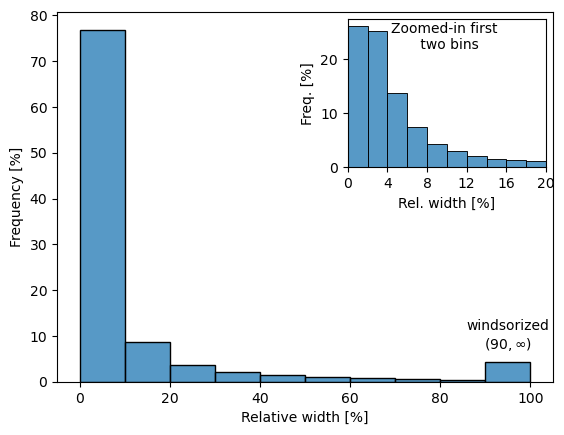

In [108]:
# plot frequecy of relative widths 
sns.histplot(res_windsorized.loc[:, 'rel_width'], bins=10, stat='percent')
plt.xlabel("Relative width [%]")
plt.ylabel("Frequency [%]")

plt.text(95, 10, "windsorized\n$(90,\infty)$", verticalalignment='center', horizontalalignment='center', fontsize=10)


# add sublot of the same kind with the zoomed in version of the plot for x in [0, 20]
ax_inset = inset_axes(plt.gca(), width="40%", height="40%", loc='upper right')

sns.histplot(res_windsorized.loc[:, 'rel_width'], bins=50, stat='percent', ax=ax_inset)
ax_inset.set_xlim(0, 20)  # Set x-axis limits to [0, 20] for the inset
ax_inset.set_ylabel('Freq. [%]')  # Hide y-axis label on the inset plot
ax_inset.set_xlabel("Rel. width [%]")  # Hide x-axis label on the inset plot
# add title inside the inset plot
ax_inset.text(0.5, 0.88, 'Zoomed-in first \n two bins', horizontalalignment='center', verticalalignment='center', transform=ax_inset.transAxes)
ax_inset.set_xticks(np.arange(0, 21, 4))

# add text to the last bin "windsorized"
plt.savefig(str(PROJ_ROOT) + "/reports/figures/real_data_replication/real1_relative_widths.png", dpi=400)
plt.show()


### Median width over true option price

In [109]:
res

,y_true,lb,ub,S,sigma,tau,r,in_interval,ill,abs_width,rel_width
245607,0.086157,0.085242,0.086863,0.974143,0.359009,0.484932,0.179664,True,False,0.001621,1.881220
109489,0.010980,0.010711,0.012225,0.918000,0.488666,0.043836,0.122613,True,False,0.001514,13.787756
206122,0.032407,0.031602,0.033972,0.700593,0.545863,0.517808,0.180749,True,False,0.002369,7.310419
20706,0.108142,0.106268,0.109577,1.086392,0.359460,0.131507,0.168285,True,False,0.003309,3.059893
46856,0.117803,0.117781,0.118714,0.892406,0.354787,1.545205,0.221426,True,False,0.000933,0.791669
...,...,...,...,...,...,...,...,...,...,...,...
80344,0.002104,0.001854,0.002416,0.819995,0.400765,0.087671,0.146535,True,False,0.000562,26.735970
191247,0.005111,0.004756,0.005574,0.867175,0.398902,0.079452,0.137691,True,False,0.000818,16.012200
88094,0.015865,0.015233,0.016169,0.712964,0.366682,0.654795,0.175006,True,False,0.000937,5.903651
68054,0.388958,0.385824,0.390893,1.384636,0.649218,0.087671,0.155909,True,False,0.005070,1.303378


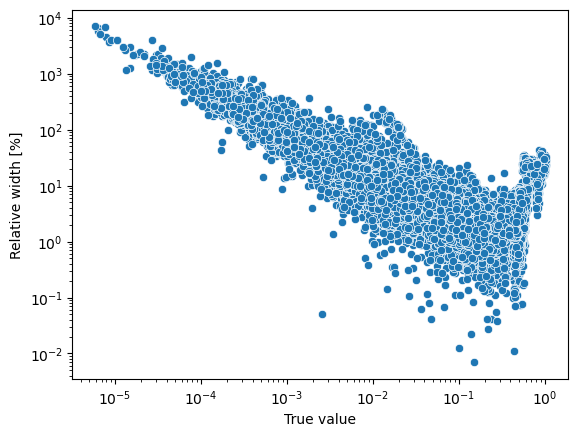

In [110]:
# plot the relative width against the true value
sns.scatterplot(data=res, x='y_true', y='rel_width')
plt.xlabel("True value")
plt.ylabel("Relative width [%]")
plt.xscale('log')
plt.yscale('log')


In [111]:
# bin the data by the true value
res.loc[:, 'y_true_bin'] = pd.cut(res.loc[:, 'y_true'], bins=10)

In [112]:
# check frequency of the bins
res.loc[:, 'y_true_bin'].value_counts()

y_true_bin
(-0.00103, 0.103]    42635
(0.103, 0.207]       12507
(0.207, 0.31]         7981
(0.31, 0.414]         5377
(0.414, 0.517]        3916
(0.517, 0.621]         701
(0.724, 0.828]         150
(0.621, 0.724]         149
(0.828, 0.931]         120
(0.931, 1.035]          85
Name: count, dtype: int64

In [113]:
# make binning along the true value with log scale
y_true_bins_seq = np.logspace(np.log10(res.loc[:, 'y_true'].min()), np.log10(res.loc[:, 'y_true'].max()), num=11)
res.loc[:, 'y_true_bin'] = pd.cut(res.loc[:, 'y_true'], bins=y_true_bins_seq, include_lowest=True)

In [114]:
res.loc[:, 'y_true_bin'].value_counts()

y_true_bin
(0.0924, 0.309]            22365
(0.0276, 0.0924]           17810
(0.309, 1.035]             10564
(0.00826, 0.0276]          10110
(0.00247, 0.00826]          6065
(0.000737, 0.00247]         3963
(0.00022, 0.000737]         2010
(6.59e-05, 0.00022]          602
(1.97e-05, 6.59e-05]         113
(-0.00099412, 1.97e-05]       19
Name: count, dtype: int64

In [115]:
# make binning along the true value with log scale
y_true_bins_seq = np.logspace(np.log10(0.00022), np.log10(res.loc[:, 'y_true'].max()), num=11)

y_true_bins_seq

array([2.20000000e-04, 5.12469071e-04, 1.19374795e-03, 2.78072228e-03,
       6.47742801e-03, 1.50885523e-02, 3.51473473e-02, 8.18724018e-02,
       1.90713971e-01, 4.44250053e-01, 1.03483824e+00])

In [116]:
res.loc[:, 'y_true_bin'] = pd.cut(res.loc[:, 'y_true'], bins=y_true_bins_seq, include_lowest=True)

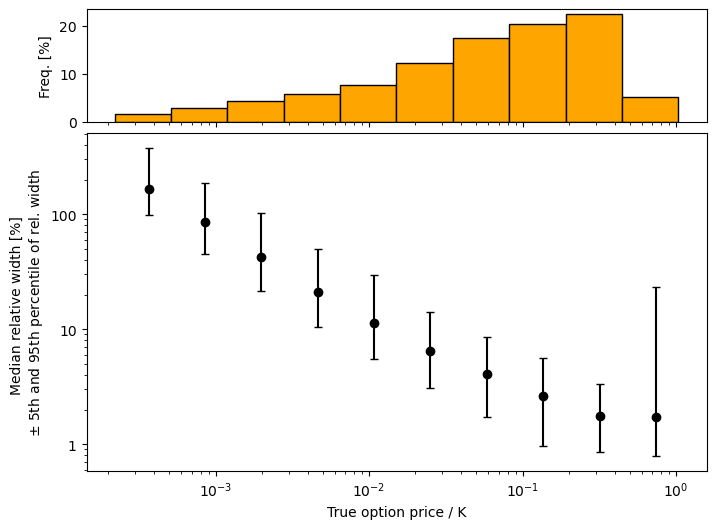

In [117]:
from matplotlib.ticker import LogFormatter


# Create the main figure and axes
fig, (ax_top, ax_main) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, sharex=True, figsize=(8, 6))
fig.subplots_adjust(hspace=0.05)  # Adjust space between subplots


# for each bin in y_true_bin, calculate the median relative width and plot it against the bin's center
bin_centers = res.groupby('y_true_bin').apply(lambda x: (x.loc[:, 'y_true'].max()+x.loc[:, 'y_true'].min())/2).values
bin_median_rel_width = res.groupby('y_true_bin').apply(lambda x: x.loc[:, 'rel_width'].median()).values

# add for each bin center its 5th and 95th percentile
bin_5th = res.groupby('y_true_bin').apply(lambda x: x.loc[:, 'rel_width'].quantile(0.05)).values
bin_95th = res.groupby('y_true_bin').apply(lambda x: x.loc[:, 'rel_width'].quantile(0.95)).values

# plt.plot(bin_centers, bin_median_rel_width, marker='o')
ax_main.errorbar(bin_centers, bin_median_rel_width, 
             yerr=[bin_median_rel_width-bin_5th, bin_95th-bin_median_rel_width], 
             color = 'black',
             capsize=3,
             fmt='o')

ax_main.set_yscale('log')  # Set log scale for the x-axis

#plt.xscale('log')
#plt.yscale('log')
#plt.xlabel("True option price / K")
#plt.ylabel("Median relative width \n$\pm$ 5th and 95th percentile of rel. width")
ax_main.set_xscale('log')  # Set log scale for the x-axis
ax_main.set_xlabel("True option price / K")
ax_main.set_ylabel("Median relative width [%] \n$\pm$ 5th and 95th percentile of rel. width")

# Customize y-axis to display plain numbers instead of scientific notation
ax_main.yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.5)))
ax_main.yaxis.set_minor_formatter(LogFormatter(labelOnlyBase=False))

bin_counts = res.loc[:, 'y_true_bin'].value_counts().sort_index().values
bin_counts_rel = 100*bin_counts / bin_counts.sum()

# Plot the counts of each bin in the top subplot
ax_top.bar(bin_centers, bin_counts_rel, width=np.diff(y_true_bins_seq), color='orange', edgecolor='black', align='center')

ax_top.set_ylabel('Freq. [%]')
#ax_top.set_title('Counts in Each Bin')

plt.savefig(str(PROJ_ROOT) + "/reports/figures/real_data_replication/real1_rel_widths_to_opt_price.png", dpi=400)
plt.show()



## Median width over features

In [ ]:
labels_list = {'S': 'S/K', 
               'sigma': r'$\sigma$', 
               'tau': r'$\tau$ [years]', 
               'r': 'r [%]'}

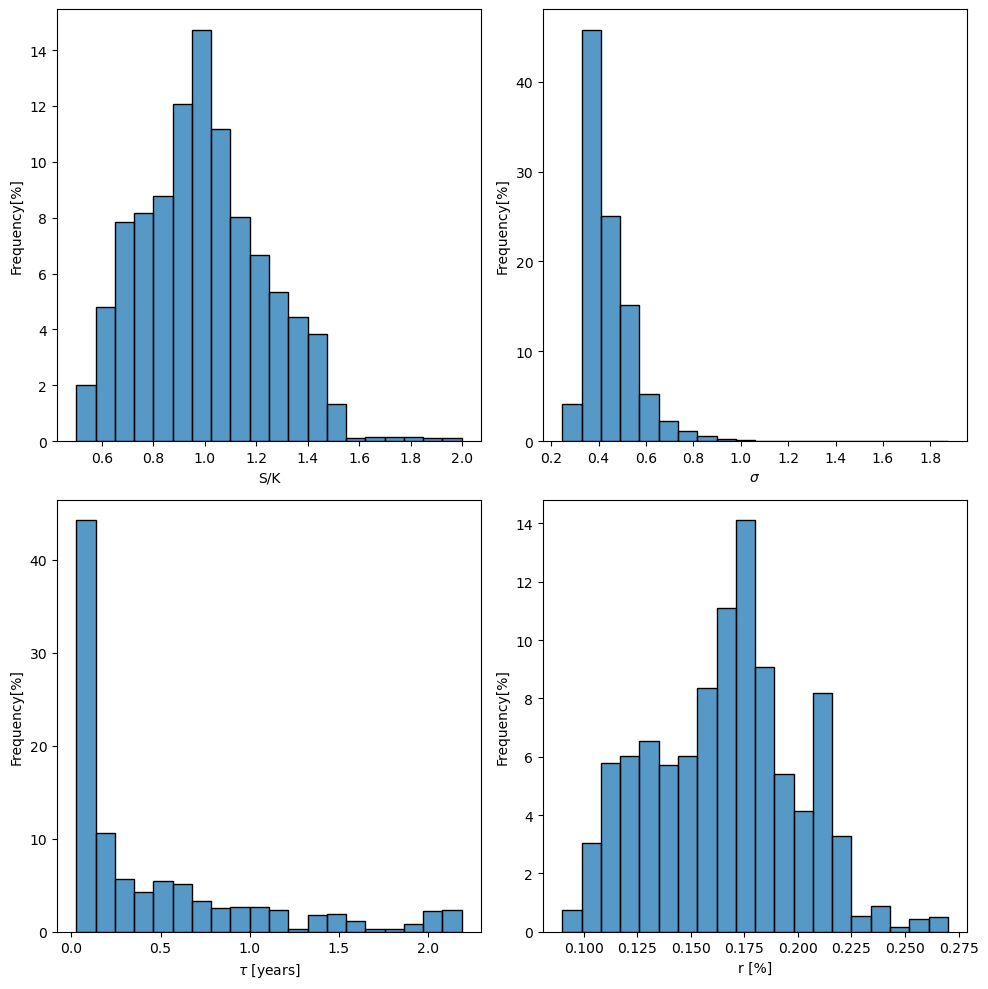

In [142]:
# plot dist of features ['S', 'sigma', 'tau', 'r']
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for i, feature in enumerate(['S', 'sigma', 'tau', 'r']):
    sns.histplot(res.loc[:, feature], ax=axes[i//2, i%2], bins=20, stat='percent')
    axes[i//2, i%2].set_xlabel(labels_list[feature])
    axes[i//2, i%2].set_ylabel('Frequency[%]')

# tight
plt.tight_layout()

plt.savefig(str(PROJ_ROOT) + "/reports/figures/real_data_replication/real1_feature_distributions.png", dpi=400)

In [129]:
# bin the data by S
res.loc[:, 'S_bin'] = pd.qcut(res.loc[:, 'S'], q=10)

# bin the data by sigma
res.loc[:, 'sigma_bin'] = pd.qcut(res.loc[:, 'sigma'], q=10)

# bin the data by tau
res.loc[:, 'tau_bin'] = pd.qcut(res.loc[:, 'tau'], q=10)

# bin the data by r
res.loc[:, 'r_bin'] = pd.qcut(res.loc[:, 'r'], q=10)


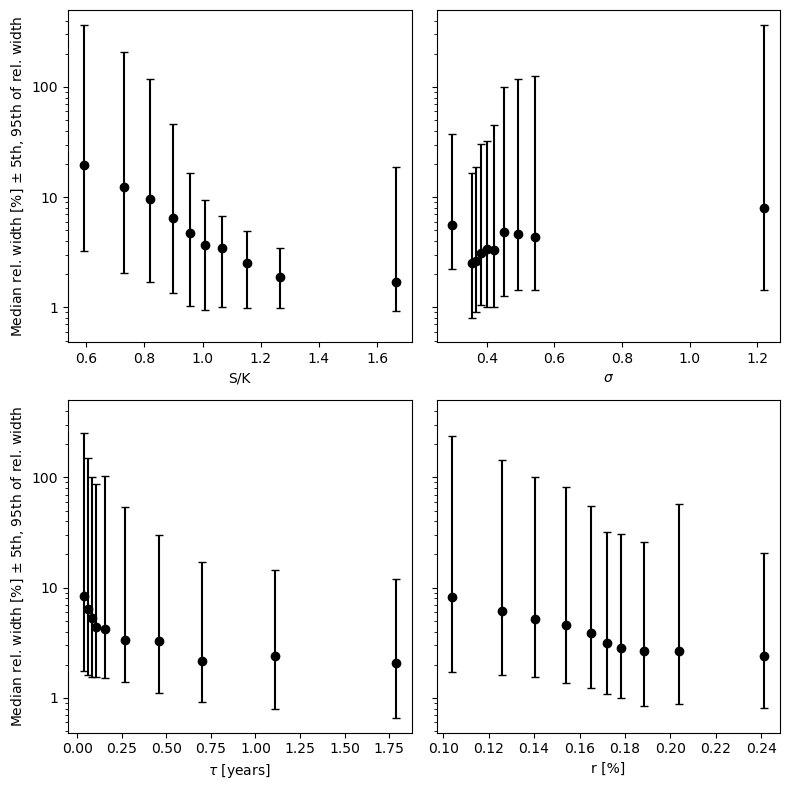

In [131]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey=True)


for i, feature in enumerate(['S', 'sigma', 'tau', 'r']):
    bin_centers = res.groupby(feature+'_bin').apply(lambda x: (x.loc[:, feature].max()+x.loc[:, feature].min())/2).values
    bin_median_rel_width = res.groupby(feature+'_bin').apply(lambda x: x.loc[:, 'rel_width'].median()).values
    #bin_widths = res.groupby(feature+'_bin').apply(lambda x: (x.loc[:, feature].max()-x.loc[:, feature].min()))).values

    # add for each bin center its 5th and 95th percentile
    bin_5th = res.groupby(feature+'_bin').apply(lambda x: x.loc[:, 'rel_width'].quantile(0.05)).values
    bin_95th = res.groupby(feature+'_bin').apply(lambda x: x.loc[:, 'rel_width'].quantile(0.95)).values
    
    #sns.histplot(res.loc[:, feature], ax=axes[i//2, i%2], bins=50)
    axes[i//2, i%2].errorbar(bin_centers, bin_median_rel_width, 
             yerr=[bin_median_rel_width-bin_5th, bin_95th-bin_median_rel_width], 
             color = 'black',
             capsize=3,
             fmt='o')
    axes[i//2, i%2].set_xlabel(labels_list[feature])
    #axes[i//2, i%2].set_ylabel("Median rel. width [%] $\pm$ 5th, 95th of rel. width")
    axes[i//2, i%2].set_yscale('log')
    
    if i%2==0:
        axes[i//2, i%2].set_ylabel('Median rel. width [%] $\pm$ 5th, 95th of rel. width')
    
    axes[i//2, i%2].yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.5)))
    axes[i//2, i%2].yaxis.set_minor_formatter(LogFormatter(labelOnlyBase=False))

# tight
plt.tight_layout()

# save
plt.savefig(str(PROJ_ROOT) + "/reports/figures/real_data_replication/real1_rel_widths_to_features.png", dpi=400)

# Load results from `run_real1`

In [132]:
multi_split_run = pd.read_csv(str(PROJ_ROOT) + "/run_real1/results_test.csv")
multi_split_run

,seed,coverage,pp_valid_pct,valid_pct
0,0,0.898065,92.824382,99.900942
1,1,0.899625,92.650691,99.887372
2,2,0.898933,92.863734,99.887372
3,3,0.896993,93.185334,99.876516
4,4,0.898947,92.805384,99.858876
...,...,...,...,...
95,95,0.897766,92.718539,99.876516
96,96,0.902746,93.056423,99.881944
97,97,0.899069,92.745678,99.879230
98,98,0.901254,92.574701,99.835808


In [133]:
multi_split_run.describe()

,seed,coverage,pp_valid_pct,valid_pct
count,100.000000,100.000000,100.000000,100.000000
mean,49.500000,0.899623,92.756778,99.868863
std,29.011492,0.001693,0.203388,0.015191
min,0.000000,0.895120,92.372513,99.834451
25%,24.750000,0.898299,92.587931,99.858876
50%,49.500000,0.899646,92.755177,99.869053
75%,74.250000,0.900891,92.866448,99.877873
max,99.000000,0.902746,93.202974,99.900942


In [124]:
multi_split_run.describe().to_csv(str(PROJ_ROOT) + "/reports/tables/multi_split_run_describe.csv")

In [125]:
## TODO analysis of these results
# - distribution of the coverage for 100 runs

In [136]:
multi_split_run.loc[:, 'coverage'].mean()

0.8996234428854452

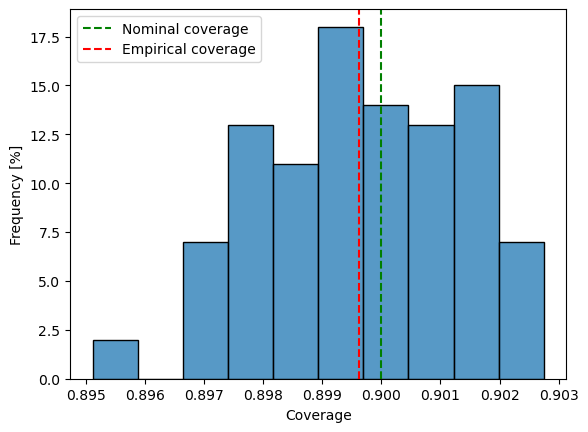

In [141]:
# plot histogram of the coverage
sns.histplot(multi_split_run.loc[:, 'coverage'], bins=10, stat='percent')
# add line for the 90% coverage
plt.axvline(0.9, color='green', linestyle='--', label='Nominal coverage')
plt.axvline(multi_split_run.loc[:, 'coverage'].mean(), 
            color='red',
            linestyle='--',
            label='Empirical coverage')
plt.xlabel("Coverage")
plt.ylabel("Frequency [%]")
plt.legend()

plt.savefig(str(PROJ_ROOT) + "/reports/figures/real_data_replication/real1_coverage_hist.png", dpi=400)